## N-step Sarsa Algorithm

In [125]:
import matplotlib.pyplot as plt
import numpy as np

In [126]:
class WindyGridWorld_Stochastic:
    '''
    Stochastic Windy Grid World with wind direction disturbance.
    The wind can blow either up or down with equal probability.
    '''
    def __init__(self, width=10, height=7):
        self.width = width
        self.height = height
        self.start = 4*width # tuple coord: (0, 3)  
        self.goal = 3*width + 7
        self.state_pos = self.start
        self.windy_cells = [y * width + x for y in range(1, 5) for x in range(4, 7)]  # 上界之风的格子
        self.windy_strength = 1 # 风力大小

    def reset(self):
        self.state_pos = self.start
        return self.start
    
    def step(self, state, action):
        action_set = [[0, 1], [0, -1], [-1, 0], [1, 0]]  # 上，下，左，右
        # extract 1d state_index to 2d position
        y = np.floor(state/self.width)
        x = state - y * self.width
        # apply action
        x = min(max(0, x + action_set[action][0]), self.width - 1)
        y = min(max(0, y + action_set[action][1]), self.height - 1)
        # apply wind disturbance and ensure y is within bounds
        if state in self.windy_cells:
            if np.random.rand() < 0.25:
                y = max(0, y - self.windy_strength) # 上移1格
            else:
                y = min(self.height - 1, y + self.windy_strength) # 下移1格
        
        # obtain next state from coord x,y
        next_state = round(y*self.width + x)
        reward = -1 if next_state != self.goal else 0
        done = next_state == self.goal
        self.state_pos = next_state
        return next_state, reward, done       

In [127]:
# n-step Sarsa for Windy Grid World
class n_Sarsa:
    '''
    n-step Sarsa algorithm implementation.
    with epsilon-greedy policy.
    '''
    # the state below is 1d-indexed

    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4, n_steps=5):
        self.ncol = ncol
        self.nrow = nrow
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.pi = np.ones([nrow * ncol, n_action]) / n_action
        self.epsilon = epsilon
        self.n_steps = n_steps

        self.state_buffer = []  # 用于存储状态
        self.action_buffer = [] # 用于存储动作
        self.reward_buffer = [] # 用于存储奖励

    def action_selection(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def n_Sarsa_main(self, env, eposides, max_step=500):
        reward_list = np.zeros(eposides)
        step_list = np.zeros(eposides)

        for ep in range(eposides):
            state = env.reset()
            action = self.action_selection(state)
            done = False
            self.state_buffer = [state]
            self.action_buffer = [action]
            T_epoch = max_step + 1  # T_epoch is the time step when the episode ends
            time_delay = step_list[ep] - self.n_steps + 1
            while step_list[ep] < max_step and time_delay < T_epoch:
                # record state, action, reward
                if step_list[ep] < T_epoch:
                    next_state, reward, done = env.step(state, action)
                    self.state_buffer.append(next_state)
                    self.reward_buffer.append(reward)
                    if done:
                        # next_state is termination state, no action to take
                        T_epoch = step_list[ep] + 1
                    else:
                        next_action = self.action_selection(next_state)
                        self.action_buffer.append(next_action)
                time_delay = step_list[ep] - self.n_steps + 1
                if len(self.state_buffer) == self.n_steps:
                    # calculate return
                    G = 0
                    for i in range(min(self.n_steps, len(self.reward_buffer))):
                        G += (self.gamma ** i) * self.reward_buffer[i]
                    if not done:
                        # add expected Q(S_{t+n},A_{t+n}) if not done
                        G += (self.gamma ** self.n_steps) * self.Q_table[self.state_buffer[-1], action]
                    # update Q(s_delayed,a_delayed)
                    state_delayed = self.state_buffer.pop(0)  # get and remove the first state in the buffer
                    action_delayed = self.action_buffer.pop(0)  # get and remove the first action in the buffer
                    self.Q_table[state_delayed, action_delayed] += self.alpha * (G - self.Q_table[state_delayed, action_delayed])
                # update step count
                step_list[ep] += 1
                # record the total reward for this episode
                reward_list[ep] = sum(self.reward_buffer)
                # update state and action for the next step
                state = next_state
                action = next_action
                    
            # Print average reward for each 10 episodes
            if (ep + 1) % 10 == 0:
                print(f'Episode {ep + 1}/{eposides}, Average Reward: {np.mean(reward_list[max(0, ep - 9):ep + 1])}')
            
            # clear buffer
            self.state_buffer.clear()
            self.action_buffer.clear()
            self.reward_buffer.clear()
        # policy extraction
        policy = np.argmax(self.Q_table, axis=1)
        return reward_list, step_list, self.Q_table, policy         

    

Episode 10/300, Average Reward: -159.1
Episode 20/300, Average Reward: -82.5
Episode 30/300, Average Reward: -58.8
Episode 40/300, Average Reward: -39.0
Episode 50/300, Average Reward: -28.2
Episode 60/300, Average Reward: -32.5
Episode 70/300, Average Reward: -41.0
Episode 80/300, Average Reward: -37.4
Episode 90/300, Average Reward: -20.9
Episode 100/300, Average Reward: -25.2
Episode 110/300, Average Reward: -8.0
Episode 120/300, Average Reward: -10.6
Episode 130/300, Average Reward: -10.5
Episode 140/300, Average Reward: -14.1
Episode 150/300, Average Reward: -10.3
Episode 160/300, Average Reward: -10.3
Episode 170/300, Average Reward: -18.0
Episode 180/300, Average Reward: -13.3
Episode 190/300, Average Reward: -11.8
Episode 200/300, Average Reward: -11.1
Episode 210/300, Average Reward: -10.1
Episode 220/300, Average Reward: -11.5
Episode 230/300, Average Reward: -10.4
Episode 240/300, Average Reward: -11.0
Episode 250/300, Average Reward: -9.4
Episode 260/300, Average Reward: -1

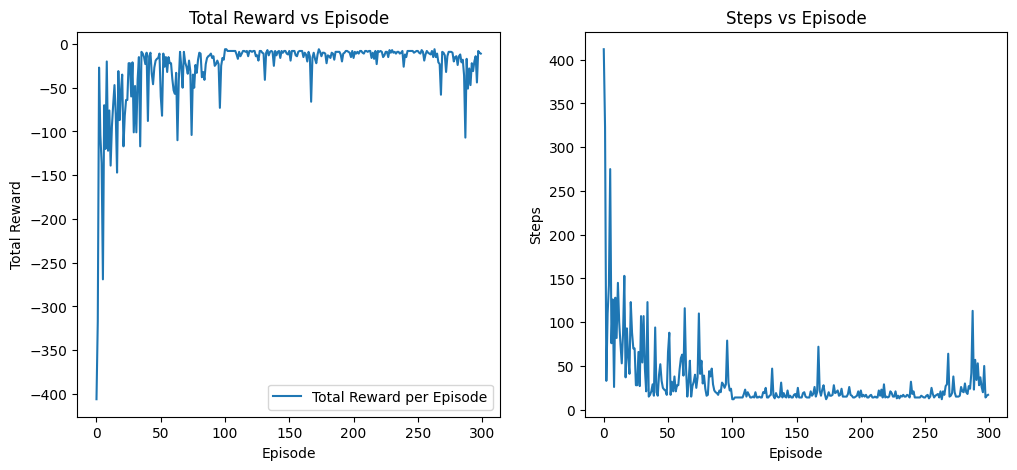

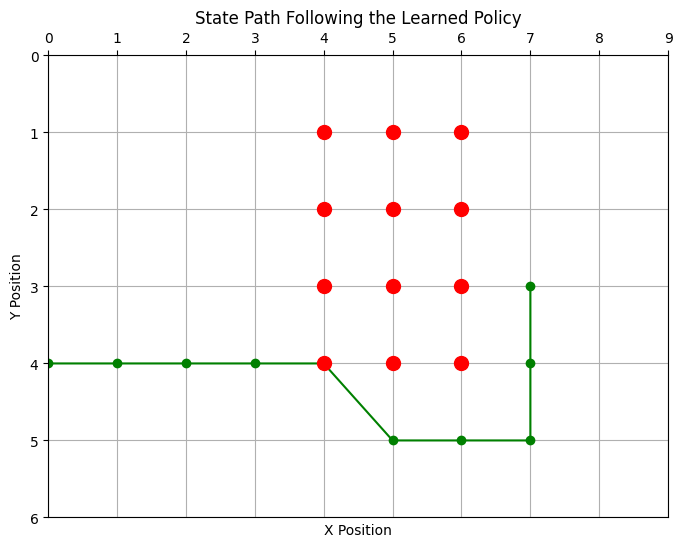

In [128]:
## Main Program for Basic Sarsa
# initialize environment and parameters
env = WindyGridWorld_Stochastic()
np.random.seed(1)  # 设置随机种子以便复现
ncol = env.width
nrow = env.height
epsilon = 0.1
alpha = 0.1 # learning rate(approximation of 1/N)
gamma = 0.85  # discount factor
agent = n_Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 300

# Train the agent
reward_list, step_ep_list, Q_table, policy = agent.n_Sarsa_main(env, num_episodes)
# Simulate the learned policy
state_policy_list = []
action_policy_list = []
done = False
sim_step = 0
reward_total = 0
env.reset()  # 重置环境
state_policy_list.append(env.state_pos)  # 记录初始状态
while (not done) and sim_step < 100:
    state = env.state_pos  # 获取当前状态
    action = policy[state]  # 从初始状态获取动作
    nxt_state, reward, done = env.step(env.state_pos, action)
    reward_total += reward
    # record the state and action
    state_policy_list.append(env.state_pos)
    action_policy_list.append(action)
    # update the state_idx
    state = nxt_state
    # check if the goal is reached
    if env.state_pos == env.goal:
        done = True
    sim_step += 1

# Plot the learning results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(reward_list, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(step_ep_list, label='Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps vs Episode')
plt.show()

# Plot the simulation
plt.figure(figsize=(8, 6))

# extract the x and y coordinates from the state_policy_list
state_policy_list_coord = [(s % ncol, s // ncol) for s in state_policy_list]  # Convert to (x, y) coordinates

# Plot the path taken by the agent
plt.plot(*zip(*state_policy_list_coord), marker='o', label='State Path', color='green')
plt.grid(True)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('State Path Following the Learned Policy')
plt.xlim(0, ncol-1)
plt.ylim(0, nrow-1)
plt.gca().invert_yaxis()  # Invert y-axis to match grid orientation
plt.gca().xaxis.set_ticks_position('top')

# Plot the windy cells
for cell in env.windy_cells:
    plt.plot(cell % ncol, cell // ncol, 'ro', markersize=10, label='Windy Cell' if cell == env.windy_cells[0] else "")

